In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("student_sleep_patterns.csv")

# Split dataset into train and test right after loading
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sleep_Quality'])

# Create Sleep_Quality_Category in both train and test (use same bins and labels)
bins = [df['Sleep_Quality'].min() - 1, 4, 7, df['Sleep_Quality'].max() + 1]
labels = [0, 1, 2]  # 0=Low, 1=Medium, 2=High

train_df['Sleep_Quality_Category'] = pd.cut(train_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)
test_df['Sleep_Quality_Category'] = pd.cut(test_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)

# Drop Student_ID if present
if 'Student_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Student_ID'])
if 'Student_ID' in test_df.columns:
    test_df = test_df.drop(columns=['Student_ID'])

# Encode categorical variables (fit on train, transform on train and test)
cat_cols = train_df.select_dtypes(include='object').columns
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    le_dict[col] = le

# Prepare features and targets
X_train = train_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_train = train_df['Sleep_Quality_Category']

X_test = test_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_test = test_df['Sleep_Quality_Category']

# Scale features for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Spectral clustering on train set
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train_scaled)

# Train Random Forest classifier to predict clusters on train features
from sklearn.ensemble import RandomForestClassifier
rf_cluster = RandomForestClassifier(random_state=42, n_estimators=100)
rf_cluster.fit(X_train, train_clusters)

# Predict clusters for test set
test_clusters = rf_cluster.predict(X_test)

# Add cluster labels as a new feature to train and test sets
X_train['Spectral_Cluster'] = train_clusters
X_test['Spectral_Cluster'] = test_clusters

# Define the Linear Discriminant Analysis classifier for final prediction
lda = LinearDiscriminantAnalysis()

# Fit LDA on training data
lda.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = lda.predict(X_train)
y_test_pred = lda.predict(X_test)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


Train Accuracy: 0.4300
Test Accuracy: 0.3600

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.42      0.74      0.53        42
           1       0.24      0.17      0.20        29
           2       0.00      0.00      0.00        29

    accuracy                           0.36       100
   macro avg       0.22      0.30      0.24       100
weighted avg       0.24      0.36      0.28       100



In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("student_sleep_patterns.csv")

# Split dataset into train and test right after loading
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sleep_Quality'])

# Create Sleep_Quality_Category in both train and test (use same bins and labels)
bins = [df['Sleep_Quality'].min() - 1, 4, 7, df['Sleep_Quality'].max() + 1]
labels = [0, 1, 2]  # 0=Low, 1=Medium, 2=High

train_df['Sleep_Quality_Category'] = pd.cut(train_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)
test_df['Sleep_Quality_Category'] = pd.cut(test_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)

# Drop Student_ID if present
if 'Student_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Student_ID'])
if 'Student_ID' in test_df.columns:
    test_df = test_df.drop(columns=['Student_ID'])

# Encode categorical variables (fit on train, transform on train and test)
cat_cols = train_df.select_dtypes(include='object').columns
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    le_dict[col] = le

# Prepare features and targets
X_train = train_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_train = train_df['Sleep_Quality_Category']

X_test = test_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_test = test_df['Sleep_Quality_Category']

# Scale features for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Spectral clustering on train set
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train_scaled)

# Train Random Forest classifier to predict clusters on train features
rf_cluster = RandomForestClassifier(random_state=42, n_estimators=100)
rf_cluster.fit(X_train, train_clusters)

# Predict clusters for test set
test_clusters = rf_cluster.predict(X_test)

# Add cluster labels as a new feature to train and test sets
X_train['Spectral_Cluster'] = train_clusters
X_test['Spectral_Cluster'] = test_clusters

# Define the Random Forest classifier for final prediction
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid to tune
param_grid = {
    'n_estimators': [50, 100, 200],          # number of trees
    'max_depth': [None, 5, 10, 20],          # max tree depth
    'min_samples_split': [2, 5, 10],         # minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]             # minimum samples per leaf node
}

# Setup GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Best model from grid search
best_rf = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Predict with best model
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE for train
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate RMSE for test
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Train Accuracy: 0.8175
Test Accuracy: 0.3600

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.41      0.83      0.55        42
           1       0.11      0.03      0.05        29
           2       0.00      0.00      0.00        29

    accuracy                           0.36       100
   macro avg       0.17      0.29      0.20       100
weighted avg       0.20      0.36      0.24       100

Train RMSE: 0.6782
Test RMSE: 1.2166


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE  # For oversampling minority classes

# Load dataset
df = pd.read_csv("student_sleep_patterns.csv")

# Split dataset into train and test right after loading
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sleep_Quality'])

# Create Sleep_Quality_Category in both train and test (use same bins and labels)
bins = [df['Sleep_Quality'].min() - 1, 4, 7, df['Sleep_Quality'].max() + 1]
labels = [0, 1, 2]  # 0=Low, 1=Medium, 2=High

train_df['Sleep_Quality_Category'] = pd.cut(train_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)
test_df['Sleep_Quality_Category'] = pd.cut(test_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)

# Drop Student_ID if present
if 'Student_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Student_ID'])
if 'Student_ID' in test_df.columns:
    test_df = test_df.drop(columns=['Student_ID'])

# Encode categorical variables (fit on train, transform on train and test)
cat_cols = train_df.select_dtypes(include='object').columns
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    le_dict[col] = le

# Prepare features and targets
X_train = train_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_train = train_df['Sleep_Quality_Category']

X_test = test_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_test = test_df['Sleep_Quality_Category']

# Scale features for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Spectral clustering on train set
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train_scaled)

# Train Random Forest classifier to predict clusters on train features
rf_cluster = RandomForestClassifier(random_state=42, n_estimators=100)
rf_cluster.fit(X_train, train_clusters)

# Predict clusters for test set
test_clusters = rf_cluster.predict(X_test)

# Add cluster labels as a new feature to train and test sets
X_train['Spectral_Cluster'] = train_clusters
X_test['Spectral_Cluster'] = test_clusters

# Use SMOTE to oversample minority classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define Random Forest classifier with balanced class weights to handle any residual imbalance
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define hyperparameter grid for RandomizedSearchCV
from scipy.stats import randint
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Setup RandomizedSearchCV with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit on resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_rf = random_search.best_estimator_
print(f"Best Hyperparameters: {random_search.best_params_}")

# Predict on test set
y_test_pred = best_rf.predict(X_test)

# Evaluate
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy after SMOTE and class_weight balancing: {test_acc:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 403}
Test Accuracy after SMOTE and class_weight balancing: 0.4000

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.51      0.55      0.53        42
           1       0.30      0.34      0.32        29
           2       0.32      0.24      0.27        29

    accuracy                           0.40       100
   macro avg       0.38      0.38      0.38       100
weighted avg       0.39      0.40      0.40       100



In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # For oversampling minority classes

# Load dataset
df = pd.read_csv("student_sleep_patterns.csv")

# Split dataset into train and test right after loading
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sleep_Quality'])

# Create Sleep_Quality_Category in both train and test (use same bins and labels)
bins = [df['Sleep_Quality'].min() - 1, 4, 7, df['Sleep_Quality'].max() + 1]
labels = [0, 1, 2]  # 0=Low, 1=Medium, 2=High

train_df['Sleep_Quality_Category'] = pd.cut(train_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)
test_df['Sleep_Quality_Category'] = pd.cut(test_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)

# Drop Student_ID if present
if 'Student_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Student_ID'])
if 'Student_ID' in test_df.columns:
    test_df = test_df.drop(columns=['Student_ID'])

# Encode categorical variables (fit on train, transform on train and test)
cat_cols = train_df.select_dtypes(include='object').columns
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    le_dict[col] = le

# Prepare features and targets
X_train = train_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_train = train_df['Sleep_Quality_Category']

X_test = test_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_test = test_df['Sleep_Quality_Category']

# Scale features for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Spectral clustering on train set
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train_scaled)

# Train Random Forest classifier to predict clusters on train features
rf_cluster = RandomForestClassifier(random_state=42, n_estimators=100)
rf_cluster.fit(X_train, train_clusters)

# Predict clusters for test set
test_clusters = rf_cluster.predict(X_test)

# Add cluster labels as a new feature to train and test sets
X_train['Spectral_Cluster'] = train_clusters
X_test['Spectral_Cluster'] = test_clusters

# Use SMOTE to oversample minority classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define Random Forest classifier with balanced class weights to handle any residual imbalance
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define hyperparameter grid for RandomizedSearchCV
from scipy.stats import randint
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Setup RandomizedSearchCV with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit on resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_rf = random_search.best_estimator_
print(f"Best Hyperparameters: {random_search.best_params_}")

# Predict on train and test sets
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Calculate accuracy for train and test
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report for test set
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Test):")
print(cm)
# Compute RMSE for train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nTrain RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 403}
Train Accuracy: 1.0000
Test Accuracy: 0.4000

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.51      0.55      0.53        42
           1       0.30      0.34      0.32        29
           2       0.32      0.24      0.27        29

    accuracy                           0.40       100
   macro avg       0.38      0.38      0.38       100
weighted avg       0.39      0.40      0.40       100


Confusion Matrix (Test):
[[23 12  7]
 [11 10  8]
 [11 11  7]]

Train RMSE: 0.0000
Test RMSE: 1.0677


C:\Users\Vimukthi\AppData\Local\Temp\ipykernel_18776\2646160074.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')


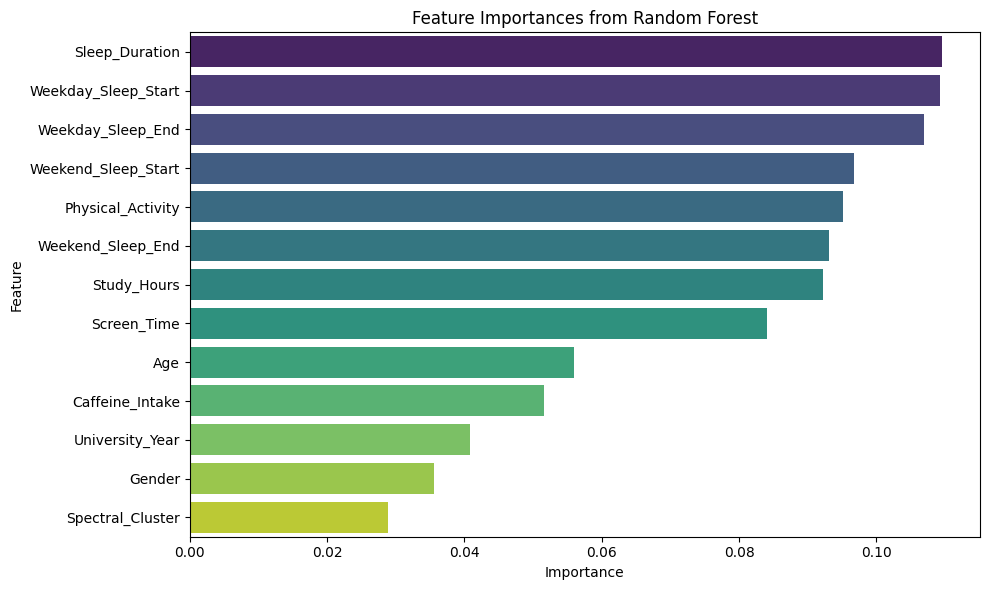

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the best RF model
importances = best_rf.feature_importances_
features = X_train.columns

# Create a DataFrame for better visualization
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort by importance descending
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='viridis')
plt.title('Feature Importances from Random Forest')
plt.tight_layout()
plt.show()


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE  # For oversampling minority classes
from scipy.stats import randint

# Load dataset
df = pd.read_csv("student_sleep_patterns.csv")

# Split dataset into train and test right after loading
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sleep_Quality'])

# Create Sleep_Quality_Category in both train and test (use same bins and labels)
bins = [df['Sleep_Quality'].min() - 1, 4, 7, df['Sleep_Quality'].max() + 1]
labels = [0, 1, 2]  # 0=Low, 1=Medium, 2=High

train_df['Sleep_Quality_Category'] = pd.cut(train_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)
test_df['Sleep_Quality_Category'] = pd.cut(test_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)

# Drop Student_ID if present
if 'Student_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Student_ID'])
if 'Student_ID' in test_df.columns:
    test_df = test_df.drop(columns=['Student_ID'])

# Encode categorical variables (fit on train, transform on train and test)
cat_cols = train_df.select_dtypes(include='object').columns
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    le_dict[col] = le

# Prepare features and targets
X_train = train_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_train = train_df['Sleep_Quality_Category']

X_test = test_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_test = test_df['Sleep_Quality_Category']

# Scale features for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Spectral clustering on train set
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train_scaled)

# Train Random Forest classifier to predict clusters on train features
rf_cluster = RandomForestClassifier(random_state=42, n_estimators=100)
rf_cluster.fit(X_train, train_clusters)

# Predict clusters for test set
test_clusters = rf_cluster.predict(X_test)

# Add cluster labels as a new feature to train and test sets
X_train['Spectral_Cluster'] = train_clusters
X_test['Spectral_Cluster'] = test_clusters

# Use SMOTE to oversample minority classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define Random Forest classifier with balanced class weights to handle any residual imbalance
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# Setup RandomizedSearchCV with 5-fold CV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)

# Fit on resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_rf = random_search.best_estimator_
print(f"Best Hyperparameters: {random_search.best_params_}")

# Predict on train and test sets using all features
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy (all features): {train_acc:.4f}")
print(f"Test Accuracy (all features): {test_acc:.4f}")

# Now select optimal number of features based on importance

# Get feature importances and feature names
importances = best_rf.feature_importances_
features = X_train.columns

# Sort features by importance
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Iterate over top-k features, train RF on them, and record test accuracy
test_accuracies = []
for k in range(1, len(features) + 1):
    top_features = feat_imp_df['Feature'].iloc[:k].tolist()
    
    X_train_top = X_train[top_features]
    X_test_top = X_test[top_features]
    
    # Train RF with same hyperparameters on subset features
    rf_top = RandomForestClassifier(random_state=42, class_weight='balanced', **random_search.best_params_)
    rf_top.fit(X_train_top, y_train)
    
    y_test_pred_top = rf_top.predict(X_test_top)
    acc = accuracy_score(y_test, y_test_pred_top)
    test_accuracies.append(acc)

# Find k with best test accuracy
best_k = np.argmax(test_accuracies) + 1
best_acc = test_accuracies[best_k - 1]
print(f"\nBest number of features: {best_k} with Test Accuracy: {best_acc:.4f}")

# Train final model with best_k features and show detailed metrics
best_features = feat_imp_df['Feature'].iloc[:best_k].tolist()
X_train_best = X_train[best_features]
X_test_best = X_test[best_features]

final_rf = RandomForestClassifier(random_state=42, class_weight='balanced', **random_search.best_params_)
final_rf.fit(X_train_best, y_train)

y_train_pred_best = final_rf.predict(X_train_best)
y_test_pred_best = final_rf.predict(X_test_best)

print(f"Train Accuracy (best features): {accuracy_score(y_train, y_train_pred_best):.4f}")
print(f"Test Accuracy (best features): {accuracy_score(y_test, y_test_pred_best):.4f}")

print("\nClassification Report (Test) with best features:")
print(classification_report(y_test, y_test_pred_best))

print("\nConfusion Matrix (Test) with best features:")
print(confusion_matrix(y_test, y_test_pred_best))
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE for Train
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
print(f"Train RMSE (best features): {train_rmse:.4f}")

# RMSE for Test
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
print(f"Test RMSE (best features): {test_rmse:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 403}
Train Accuracy (all features): 1.0000
Test Accuracy (all features): 0.4000

Best number of features: 13 with Test Accuracy: 0.4300
Train Accuracy (best features): 1.0000
Test Accuracy (best features): 0.4300

Classification Report (Test) with best features:
              precision    recall  f1-score   support

           0       0.49      0.71      0.58        42
           1       0.36      0.28      0.31        29
           2       0.29      0.17      0.22        29

    accuracy                           0.43       100
   macro avg       0.38      0.39      0.37       100
weighted avg       0.40      0.43      0.40       100


Confusion Matrix (Test) with best features:
[[30  6  6]
 [15  8  6]
 [16  8  5]]
Train RMSE (best features): 0.0000
Test RMSE (best features): 1.1091


In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from imblearn.over_sampling import SMOTE
from scipy.stats import randint

# Load dataset
df = pd.read_csv("student_sleep_patterns.csv")

# Split dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sleep_Quality'])

# Create 3-class category
bins = [df['Sleep_Quality'].min() - 1, 4, 7, df['Sleep_Quality'].max() + 1]
labels = [0, 1, 2]  # 0 = Low, 1 = Medium, 2 = High
train_df['Sleep_Quality_Category'] = pd.cut(train_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)
test_df['Sleep_Quality_Category'] = pd.cut(test_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)

# Merge into binary: 0 if Low or Medium, 1 if High
train_df['Sleep_Quality_Binary'] = train_df['Sleep_Quality_Category'].apply(lambda x: 1 if x == 2 else 0)
test_df['Sleep_Quality_Binary'] = test_df['Sleep_Quality_Category'].apply(lambda x: 1 if x == 2 else 0)

# Drop Student_ID if exists
for df_ in [train_df, test_df]:
    df_.drop(columns=[col for col in ['Student_ID'] if col in df_.columns], inplace=True)

# Encode categoricals
cat_cols = train_df.select_dtypes(include='object').columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    le_dict[col] = le

# Separate features and binary target
X_train = train_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category', 'Sleep_Quality_Binary'])
y_train = train_df['Sleep_Quality_Binary']
X_test = test_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category', 'Sleep_Quality_Binary'])
y_test = test_df['Sleep_Quality_Binary']

# Scale features for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Spectral Clustering
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train_scaled)

# Train RF to mimic clustering for test
rf_cluster = RandomForestClassifier(random_state=42, n_estimators=100)
rf_cluster.fit(X_train, train_clusters)
test_clusters = rf_cluster.predict(X_test)

# Add cluster as feature
X_train['Spectral_Cluster'] = train_clusters
X_test['Spectral_Cluster'] = test_clusters

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Random Forest setup
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='accuracy'
)
random_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_rf = random_search.best_estimator_
print(f"Best Hyperparameters: {random_search.best_params_}")

# Predictions on full feature set
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)
print(f"Train Accuracy (all features): {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy (all features): {accuracy_score(y_test, y_test_pred):.4f}")

# Feature importance ranking
importances = best_rf.feature_importances_
features = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Test accuracy for different k
test_accuracies = []
for k in range(1, len(features) + 1):
    top_features = feat_imp_df['Feature'].iloc[:k].tolist()
    rf_top = RandomForestClassifier(random_state=42, class_weight='balanced', **random_search.best_params_)
    rf_top.fit(X_train[top_features], y_train)
    y_test_pred_k = rf_top.predict(X_test[top_features])
    acc = accuracy_score(y_test, y_test_pred_k)
    test_accuracies.append(acc)

best_k = np.argmax(test_accuracies) + 1
print(f"\nBest number of features: {best_k} with Test Accuracy: {test_accuracies[best_k - 1]:.4f}")

# Final RF with best_k features
best_features = feat_imp_df['Feature'].iloc[:best_k].tolist()
final_rf = RandomForestClassifier(random_state=42, class_weight='balanced', **random_search.best_params_)
final_rf.fit(X_train[best_features], y_train)

y_train_pred_best = final_rf.predict(X_train[best_features])
y_test_pred_best = final_rf.predict(X_test[best_features])

# Evaluation
print(f"\nTrain Accuracy (best features): {accuracy_score(y_train, y_train_pred_best):.4f}")
print(f"Test Accuracy (best features): {accuracy_score(y_test, y_test_pred_best):.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_best))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_best))

# RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_best))
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 394}
Train Accuracy (all features): 0.9825
Test Accuracy (all features): 0.6500

Best number of features: 8 with Test Accuracy: 0.7400

Train Accuracy (best features): 0.9975
Test Accuracy (best features): 0.7400

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.75      0.96      0.84        71
           1       0.67      0.21      0.32        29

    accuracy                           0.74       100
   macro avg       0.71      0.58      0.58       100
weighted avg       0.72      0.74      0.69       100

Confusion Matrix (Test):
[[68  3]
 [23  6]]
Train RMSE: 0.0500
Test RMSE: 0.5099


C:\Users\Vimukthi\AppData\Local\Temp\ipykernel_18776\12364785.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15), palette='viridis')


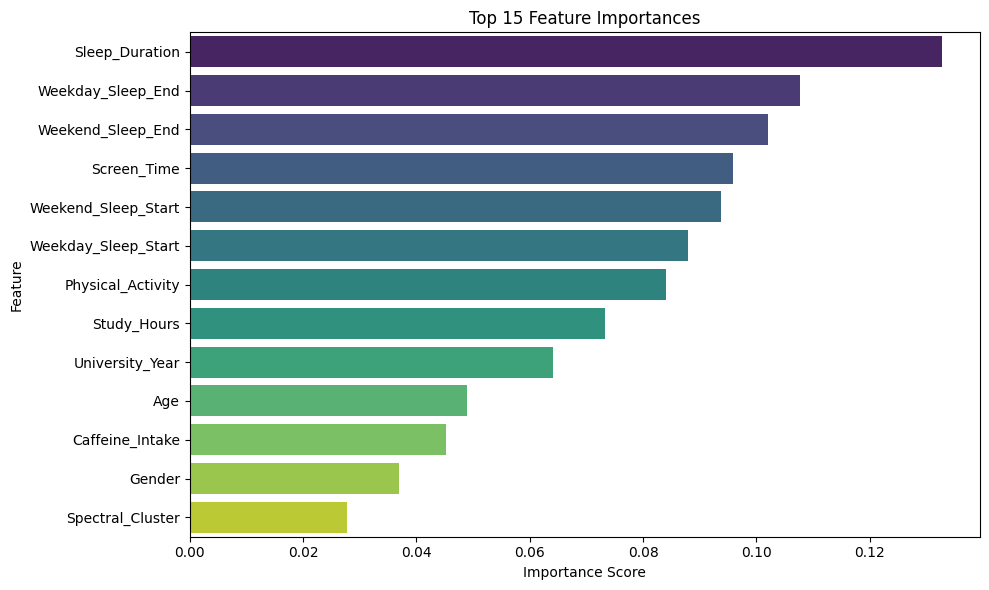

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Define the path to the folder
save_path = os.path.join("presentation", "top15_feature_importances.png")  # or .jpg, .svg, .pdf as needed

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()

# Save before showing
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # high resolution
plt.show()



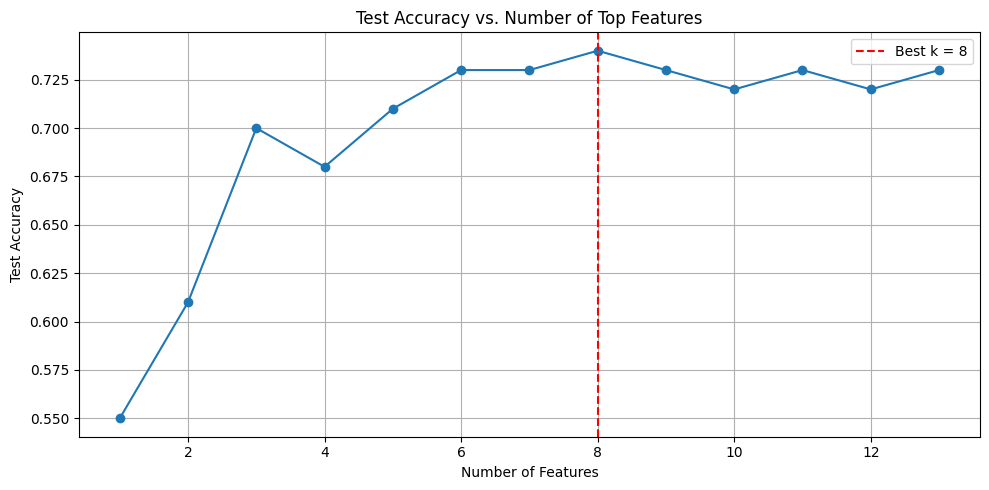

In [67]:
import os

# Define save path
save_path = os.path.join("presentation", "test_accuracy_vs_num_features.png")

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker='o')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.title('Test Accuracy vs. Number of Top Features')
plt.xlabel('Number of Features')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save before show
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()



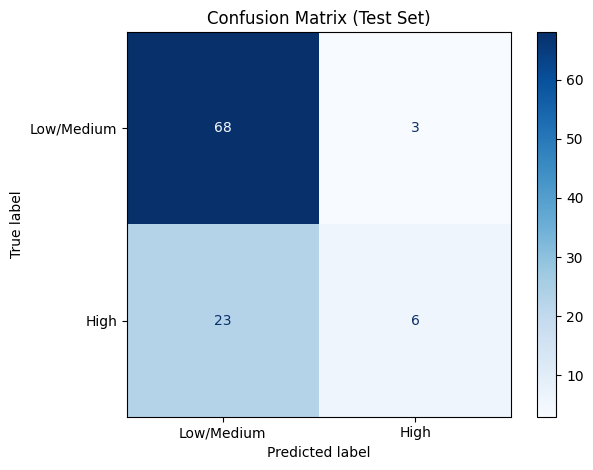

In [68]:
import os
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make sure this exists
X_test_best = X_test[best_features]

ConfusionMatrixDisplay.from_estimator(
    final_rf,
    X_test_best,
    y_test,
    display_labels=['Low/Medium', 'High'],
    cmap='Blues',
    values_format='d'
)

plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()

# Save the plot
save_path = os.path.join("presentation", "confusion_matrix_test_set.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()



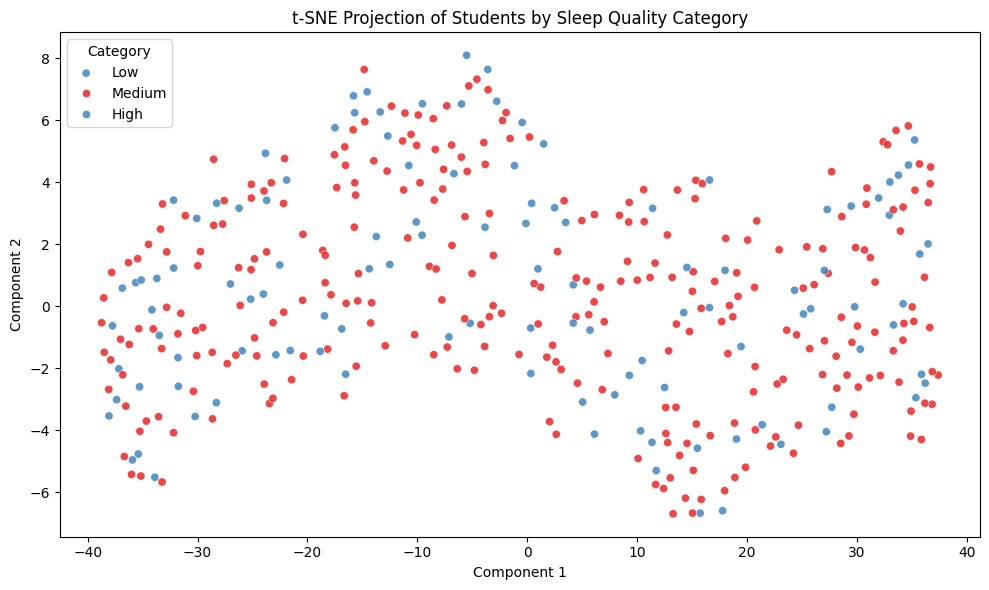

In [69]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

X_proj = TSNE(n_components=2, random_state=42).fit_transform(X_train_best)

plt.figure(figsize=(10,6))
sns.scatterplot(x=X_proj[:,0], y=X_proj[:,1], hue=y_train, palette='Set1', alpha=0.8)
plt.title("t-SNE Projection of Students by Sleep Quality Category")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Category', labels=['Low', 'Medium', 'High'])
plt.tight_layout()

# Save the plot
save_path = os.path.join("presentation", "tsne_projection_sleep_quality.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


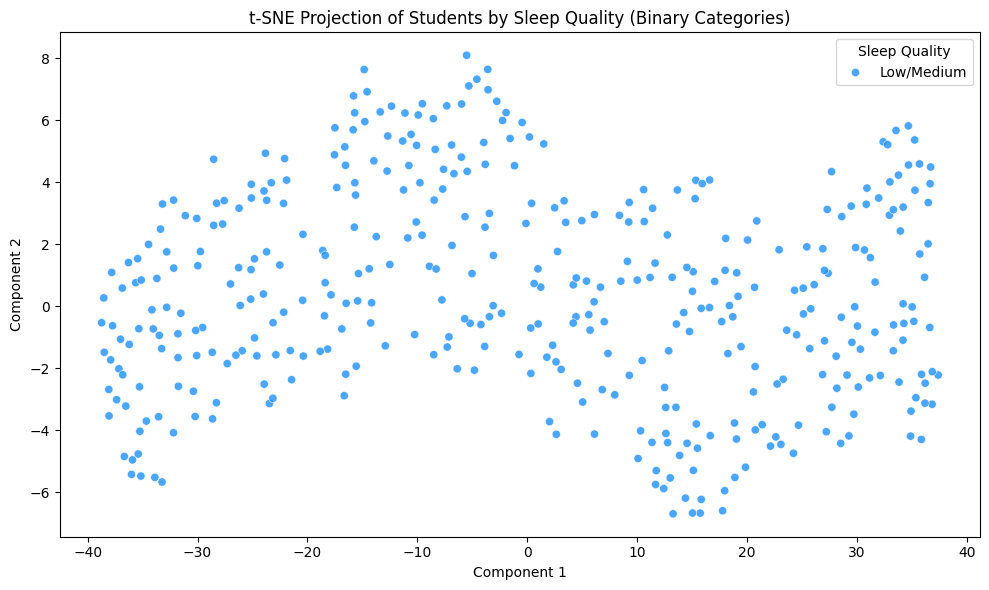

In [72]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

# Recode: 0 (Low/Medium), 1 (High)
y_train_binary = np.where(y_train < 2, 0, 1)

# Convert to Pandas Series for better compatibility with seaborn
y_binary_series = pd.Series(y_train_binary).map({0: "Low/Medium", 1: "High"})

# t-SNE projection
X_proj = TSNE(n_components=2, random_state=42).fit_transform(X_train_best)

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=X_proj[:,0],
    y=X_proj[:,1],
    hue=y_binary_series,
    palette={"Low/Medium": "dodgerblue", "High": "crimson"},
    alpha=0.8
)
plt.title("t-SNE Projection of Students by Sleep Quality (Binary Categories)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title='Sleep Quality')
plt.tight_layout()

# Save the plot
save_path = os.path.join("presentation", "tsne_projection_sleep_quality_binary.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


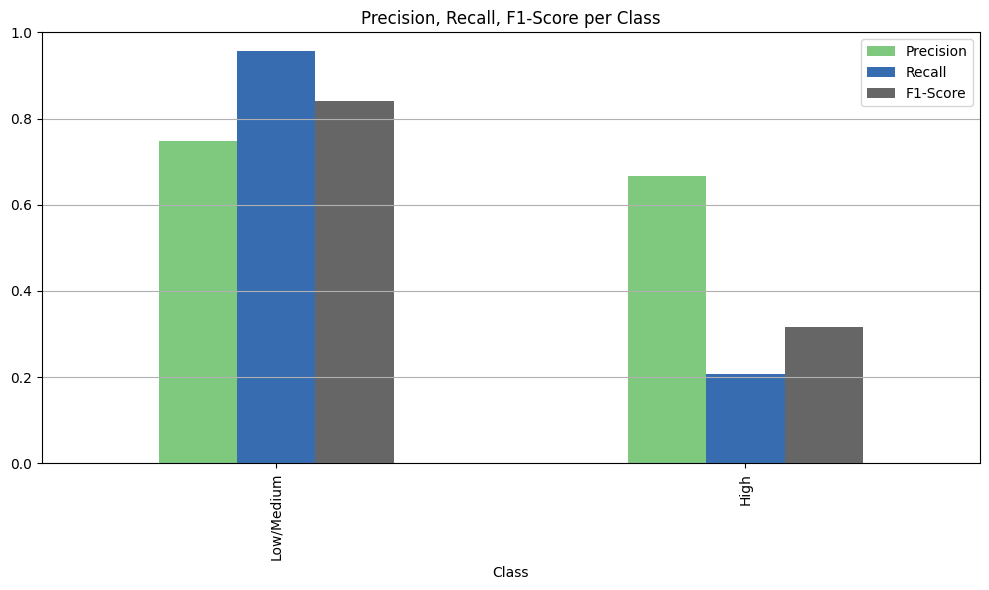

In [73]:
import os
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd

# Compute metrics for binary classification
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred_best, labels=[0, 1])

# Use binary class labels
labels = ['Low/Medium', 'High']

# Create DataFrame
metrics_df = pd.DataFrame({
    'Class': labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Plotting
ax = metrics_df.set_index('Class').plot(kind='bar', figsize=(10, 6), colormap='Accent')
plt.title("Precision, Recall, F1-Score per Class")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()

# Save the plot
save_path = os.path.join("presentation", "precision_recall_f1_per_class.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()


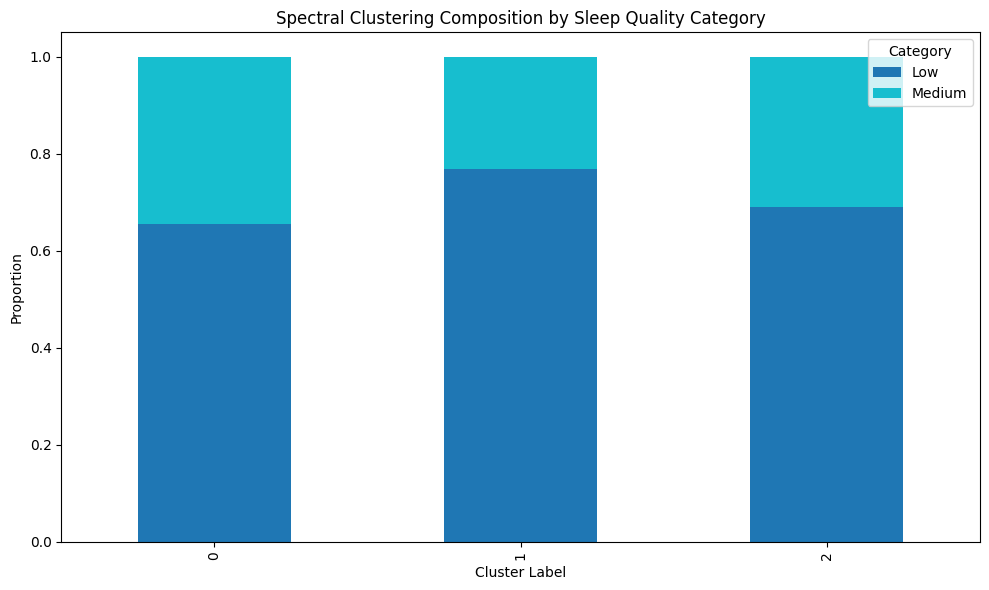

In [74]:
import os

cluster_df = pd.DataFrame({'Cluster': train_clusters, 'True_Label': y_train})
cluster_dist = pd.crosstab(cluster_df['Cluster'], cluster_df['True_Label'], normalize='index')

ax = cluster_dist.plot(kind='bar', stacked=True, colormap='tab10', figsize=(10, 6))
plt.title("Spectral Clustering Composition by Sleep Quality Category")
plt.xlabel("Cluster Label")
plt.ylabel("Proportion")
plt.legend(title="Category", labels=['Low', 'Medium', 'High'])
plt.tight_layout()

# Save plot
save_path = os.path.join("presentation", "spectral_clustering_composition.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()



In [75]:
pip install shap


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


X_test_best shape: (100, 8)
shap_values[0] shape: (8, 2)


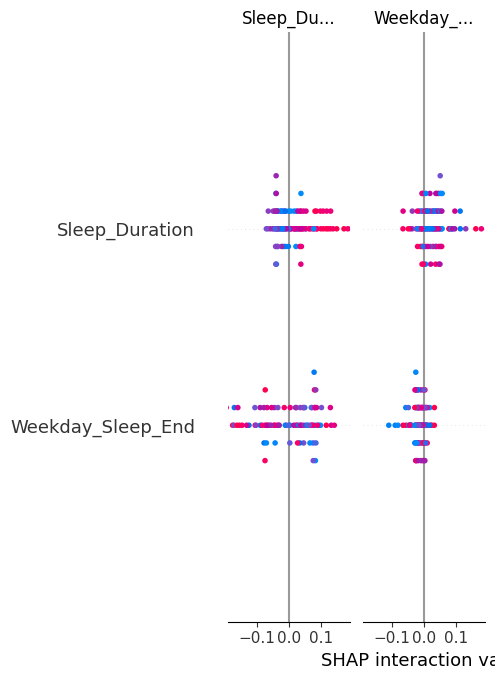

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [76]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assuming final_rf and X_test_best are defined and model is trained on X_train_best

# Convert to NumPy array (optional for SHAP but you have DataFrame already)
X_test_array = X_test_best.to_numpy()
feature_names = X_test_best.columns.tolist()

explainer = shap.TreeExplainer(final_rf)
shap_values = explainer.shap_values(X_test_best)

print("X_test_best shape:", X_test_best.shape)
print("shap_values[0] shape:", shap_values[0].shape)

# Global feature importance plot (bar)
shap.summary_plot(shap_values, X_test_best, plot_type="bar", feature_names=feature_names)
plt.savefig("presentation/shap_summary_bar.png", dpi=300, bbox_inches='tight')
plt.close()

# Class-specific summary plot for class 0 (Low)
shap.summary_plot(shap_values[0], X_test_best, feature_names=feature_names)
plt.savefig("presentation/shap_summary_class_0.png", dpi=300, bbox_inches='tight')
plt.close()


In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

misclassified = X_test_best[y_test != y_test_pred_best]
mis_labels = y_test[y_test != y_test_pred_best]

plt.figure(figsize=(8, 4))
sns.countplot(x=mis_labels, palette='coolwarm')
plt.title("Misclassified Samples per True Category")
plt.xlabel("True Category")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("presentation/misclassified_countplot.png", dpi=300, bbox_inches='tight')
plt.close()


C:\Users\Vimukthi\AppData\Local\Temp\ipykernel_18776\3285266433.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=mis_labels, palette='coolwarm')


In [78]:
print(X_train_best.columns)


Index(['Sleep_Duration', 'Weekday_Sleep_Start', 'Weekday_Sleep_End',
       'Weekend_Sleep_Start', 'Physical_Activity', 'Weekend_Sleep_End',
       'Study_Hours', 'Screen_Time', 'Age', 'Caffeine_Intake',
       'University_Year', 'Gender', 'Spectral_Cluster'],
      dtype='object')


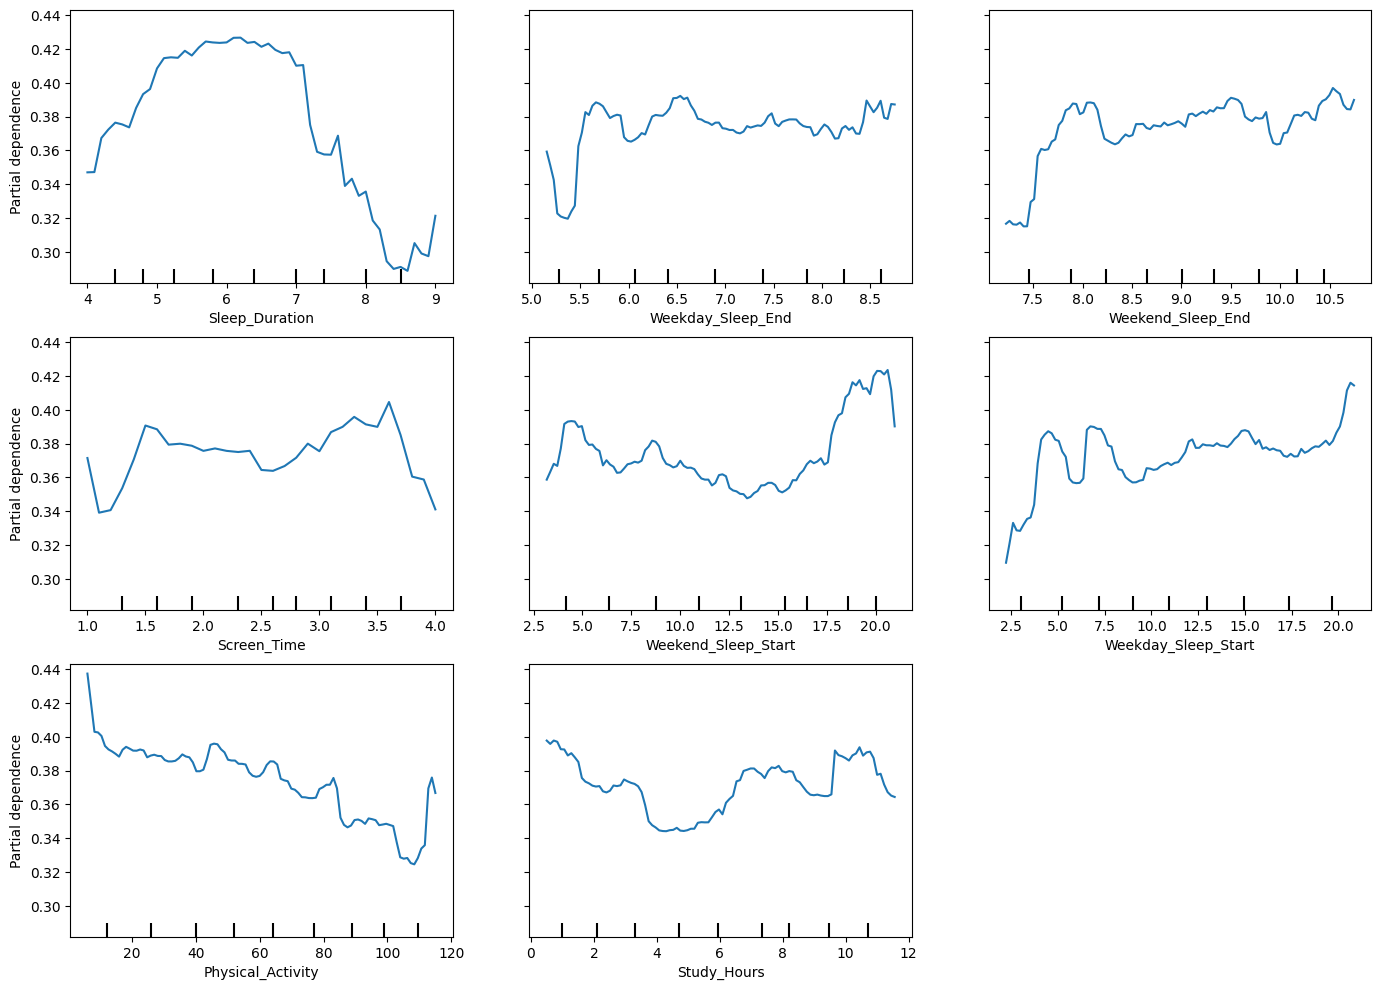

In [79]:
import os

trained_features = ['Sleep_Duration', 'Weekday_Sleep_End', 'Weekend_Sleep_End',
                    'Screen_Time', 'Weekend_Sleep_Start', 'Weekday_Sleep_Start',
                    'Physical_Activity', 'Study_Hours']

X_train_pdp = X_train_best[trained_features]

fig, ax = plt.subplots(figsize=(14, 10))
PartialDependenceDisplay.from_estimator(
    final_rf,
    X_train_pdp,
    features=trained_features,
    target=0,  # or whichever class you want
    ax=ax,
    kind='average'
)
plt.tight_layout()

# Save figure
save_path = os.path.join('presentation', 'partial_dependence_plot.png')
plt.savefig(save_path)

plt.show()




In [80]:
import os
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

trained_features = ['Sleep_Duration', 'Weekday_Sleep_End', 'Weekend_Sleep_End',
                    'Screen_Time', 'Weekend_Sleep_Start', 'Weekday_Sleep_Start',
                    'Physical_Activity', 'Study_Hours']

X_train_pdp = X_train_best[trained_features]

# Create folder if it doesn't exist
save_dir = 'presentation/pdp_plots'
os.makedirs(save_dir, exist_ok=True)

for feature in trained_features:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        final_rf,
        X_train_pdp,
        features=[feature],
        target=0,  # change if you want a different class
        ax=ax,
        kind='average'
    )
    plt.title(f'Partial Dependence Plot for {feature}')
    plt.tight_layout()
    
    # Save each plot with feature name
    save_path = os.path.join(save_dir, f'pdp_{feature}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close(fig)  # Close the figure to free memory


In [49]:
print("Model expects:", list(final_rf.feature_names_in_))
print("You passed:", list(X_train_best.columns))


Model expects: ['Sleep_Duration', 'Weekday_Sleep_End', 'Weekend_Sleep_End', 'Screen_Time', 'Weekend_Sleep_Start', 'Weekday_Sleep_Start', 'Physical_Activity', 'Study_Hours']
You passed: ['Sleep_Duration', 'Weekday_Sleep_Start', 'Weekday_Sleep_End', 'Weekend_Sleep_Start', 'Physical_Activity', 'Weekend_Sleep_End', 'Study_Hours', 'Screen_Time', 'Age', 'Caffeine_Intake', 'University_Year', 'Gender', 'Spectral_Cluster']


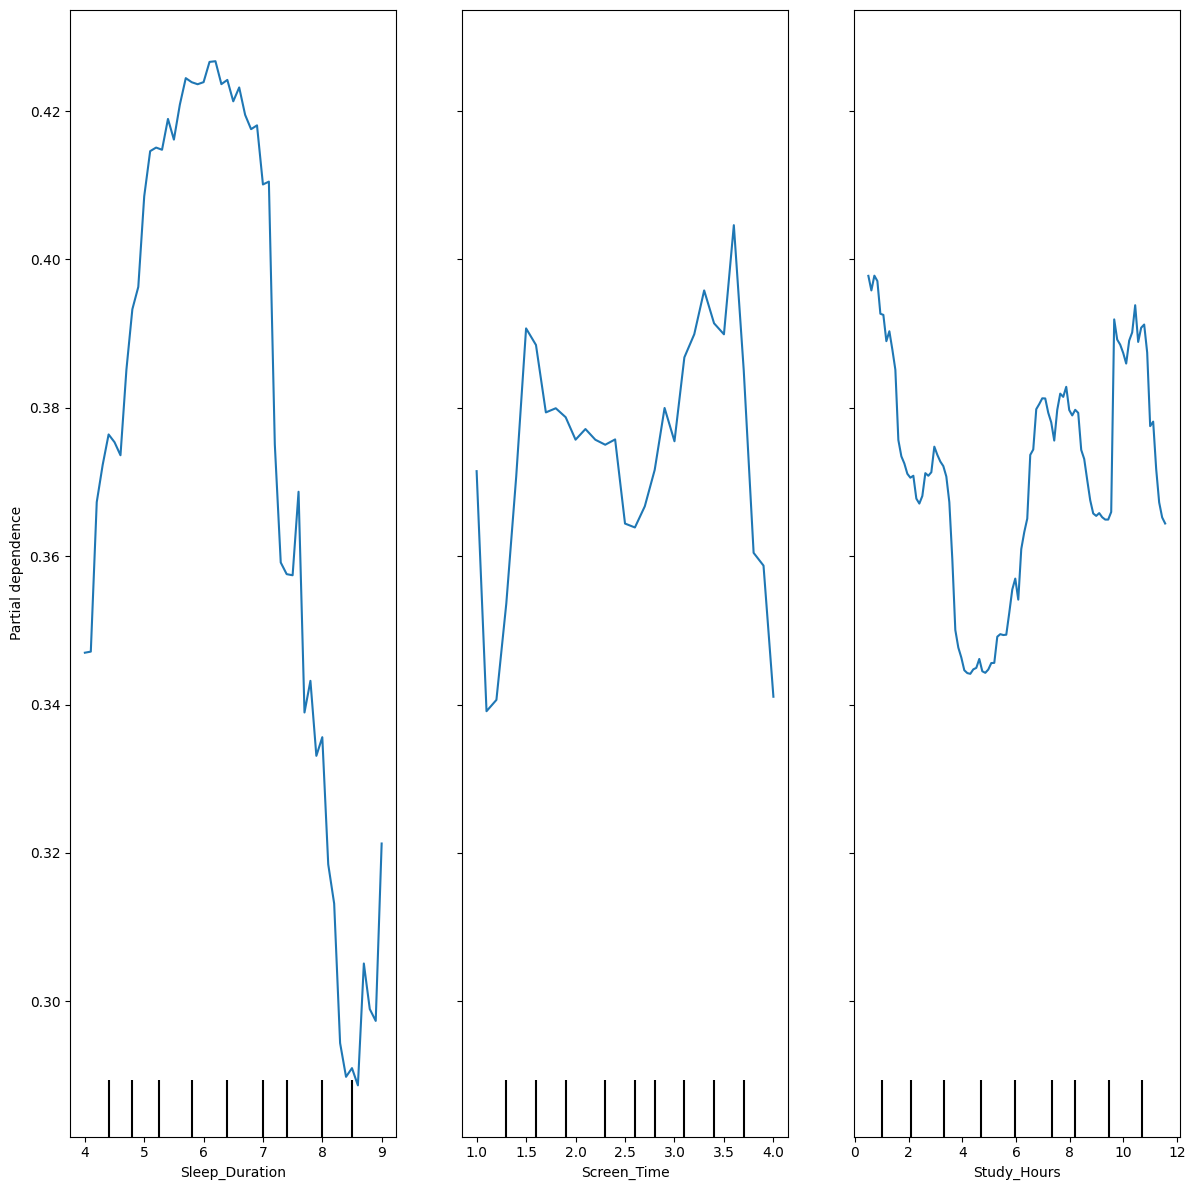

In [50]:
expected_cols = [
    'Sleep_Duration', 'Weekday_Sleep_End', 'Weekend_Sleep_End', 'Screen_Time',
    'Weekend_Sleep_Start', 'Weekday_Sleep_Start', 'Physical_Activity', 'Study_Hours'
]

# Filter and reorder your DataFrame
X_matched = X_train_best[expected_cols]

# Now draw the PDP safely
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

top_features = ['Sleep_Duration', 'Screen_Time', 'Study_Hours']  # or any subset of the 8
fig, ax = plt.subplots(figsize=(12, 4 * len(top_features)))
PartialDependenceDisplay.from_estimator(
    final_rf,
    X_matched,
    features=top_features,
    ax=ax
)
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Load dataset
df = pd.read_csv("student_sleep_patterns.csv")

# Split dataset into train and test right after loading
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sleep_Quality'])

# Create Sleep_Quality_Category in both train and test (use same bins and labels)
bins = [df['Sleep_Quality'].min() - 1, 4, 7, df['Sleep_Quality'].max() + 1]
labels = [0, 1, 2]  # 0=Low, 1=Medium, 2=High

train_df['Sleep_Quality_Category'] = pd.cut(train_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)
test_df['Sleep_Quality_Category'] = pd.cut(test_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)

# Drop Student_ID if present
if 'Student_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Student_ID'])
if 'Student_ID' in test_df.columns:
    test_df = test_df.drop(columns=['Student_ID'])

# Encode categorical variables (fit on train, transform on train and test)
cat_cols = train_df.select_dtypes(include='object').columns
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    le_dict[col] = le

# Prepare features and targets
X_train = train_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_train = train_df['Sleep_Quality_Category']

X_test = test_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_test = test_df['Sleep_Quality_Category']

# Scale features for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Spectral clustering on train set
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train_scaled)

# Train Random Forest classifier to predict clusters on train features
rf_cluster = RandomForestClassifier(random_state=42, n_estimators=100)
rf_cluster.fit(X_train, train_clusters)

# Predict clusters for test set
test_clusters = rf_cluster.predict(X_test)

# Add cluster labels as a new feature to train and test sets
X_train['Spectral_Cluster'] = train_clusters
X_test['Spectral_Cluster'] = test_clusters

# -- Option 1: Cost-sensitive Random Forest with class_weight balanced_subsample --

print("Training cost-sensitive Random Forest...")

cost_sensitive_rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced_subsample',
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2
)

cost_sensitive_rf.fit(X_train, y_train)

y_train_pred_cs = cost_sensitive_rf.predict(X_train)
y_test_pred_cs = cost_sensitive_rf.predict(X_test)

print(f"Train Accuracy (Cost-sensitive RF): {accuracy_score(y_train, y_train_pred_cs):.4f}")
print(f"Test Accuracy (Cost-sensitive RF): {accuracy_score(y_test, y_test_pred_cs):.4f}")
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_cs))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_cs))


# -- Option 2: Balanced Random Forest from imblearn --

print("\nTraining Balanced Random Forest...")

brf = BalancedRandomForestClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1
)

brf.fit(X_train, y_train)

y_train_pred_brf = brf.predict(X_train)
y_test_pred_brf = brf.predict(X_test)

print(f"Train Accuracy (Balanced RF): {accuracy_score(y_train, y_train_pred_brf):.4f}")
print(f"Test Accuracy (Balanced RF): {accuracy_score(y_test, y_test_pred_brf):.4f}")
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_brf))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_brf))


# -- Option 3: EasyEnsembleClassifier from imblearn --

print("\nTraining EasyEnsembleClassifier...")

eec = EasyEnsembleClassifier(
    random_state=42,
    n_estimators=50,
    n_jobs=-1
)

eec.fit(X_train, y_train)

y_train_pred_eec = eec.predict(X_train)
y_test_pred_eec = eec.predict(X_test)

print(f"Train Accuracy (EasyEnsemble): {accuracy_score(y_train, y_train_pred_eec):.4f}")
print(f"Test Accuracy (EasyEnsemble): {accuracy_score(y_test, y_test_pred_eec):.4f}")
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred_eec))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_eec))


Training cost-sensitive Random Forest...
Train Accuracy (Cost-sensitive RF): 1.0000
Test Accuracy (Cost-sensitive RF): 0.3600
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.45      0.60      0.52        42
           1       0.24      0.24      0.24        29
           2       0.25      0.14      0.18        29

    accuracy                           0.36       100
   macro avg       0.32      0.32      0.31       100
weighted avg       0.33      0.36      0.34       100

Confusion Matrix (Test):
[[25 12  5]
 [15  7  7]
 [15 10  4]]

Training Balanced Random Forest...
Train Accuracy (Balanced RF): 1.0000
Test Accuracy (Balanced RF): 0.3600
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.50      0.48      0.49        42
           1       0.31      0.38      0.34        29
           2       0.21      0.17      0.19        29

    accuracy                           0.36 

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report

# Load dataset
df = pd.read_csv("student_sleep_patterns.csv")

# Split dataset into train and test right after loading
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Sleep_Quality'])

# Create Sleep_Quality_Category in both train and test (use same bins and labels)
bins = [df['Sleep_Quality'].min() - 1, 4, 7, df['Sleep_Quality'].max() + 1]
labels = [0, 1, 2]  # 0=Low, 1=Medium, 2=High

train_df['Sleep_Quality_Category'] = pd.cut(train_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)
test_df['Sleep_Quality_Category'] = pd.cut(test_df['Sleep_Quality'], bins=bins, labels=labels).astype(int)

# Drop Student_ID if present
if 'Student_ID' in train_df.columns:
    train_df = train_df.drop(columns=['Student_ID'])
if 'Student_ID' in test_df.columns:
    test_df = test_df.drop(columns=['Student_ID'])

# Encode categorical variables (fit on train, transform on train and test)
cat_cols = train_df.select_dtypes(include='object').columns
le_dict = {}

for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = test_df[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)
    le_dict[col] = le

# Prepare features and targets
X_train = train_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_train = train_df['Sleep_Quality_Category']

X_test = test_df.drop(columns=['Sleep_Quality', 'Sleep_Quality_Category'])
y_test = test_df['Sleep_Quality_Category']

# Scale features for clustering
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Spectral clustering on train set
n_clusters = 3
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
train_clusters = spectral.fit_predict(X_train_scaled)

# Train Random Forest classifier to predict clusters on train features
from sklearn.ensemble import RandomForestClassifier
rf_cluster = RandomForestClassifier(random_state=42, n_estimators=100)
rf_cluster.fit(X_train, train_clusters)

# Predict clusters for test set
test_clusters = rf_cluster.predict(X_test)

# Add cluster labels as a new feature to train and test sets
X_train['Spectral_Cluster'] = train_clusters
X_test['Spectral_Cluster'] = test_clusters

# Define the Quadratic Discriminant Analysis classifier for final prediction
qda = QuadraticDiscriminantAnalysis()

# Fit QDA on training data
qda.fit(X_train, y_train)

# Predict on train and test sets
y_train_pred = qda.predict(X_train)
y_test_pred = qda.predict(X_test)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))
from sklearn.metrics import mean_squared_error
import math

# Compute RMSE for training and testing predictions
train_rmse = math.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"\nTrain RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Train Accuracy: 0.6350
Test Accuracy: 0.3600

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.42      0.60      0.50        42
           1       0.19      0.10      0.13        29
           2       0.32      0.28      0.30        29

    accuracy                           0.36       100
   macro avg       0.31      0.32      0.31       100
weighted avg       0.33      0.36      0.33       100


Train RMSE: 0.9110
Test RMSE: 1.1790


In [29]:
!pip install pingouin


   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.3 MB ? eta -:--:--
   --------------- ------------------------ 0.5/1.3 MB 1.7 MB/s eta 0:00:01
   ------------------------------- -------- 1.0/1.3 MB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 1.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


=== Shapiro-Wilk Test for Normality (per class and feature) ===

Class 0:
Age: p-value = 0.0000
Gender: p-value = 0.0000
University_Year: p-value = 0.0000
Sleep_Duration: p-value = 0.0000
Study_Hours: p-value = 0.0000
Screen_Time: p-value = 0.0001
Caffeine_Intake: p-value = 0.0000
Physical_Activity: p-value = 0.0000
Weekday_Sleep_Start: p-value = 0.0000
Weekend_Sleep_Start: p-value = 0.0000
Weekday_Sleep_End: p-value = 0.0000
Weekend_Sleep_End: p-value = 0.0001
Spectral_Cluster: p-value = 0.0000

Class 1:
Age: p-value = 0.0000
Gender: p-value = 0.0000
University_Year: p-value = 0.0000
Sleep_Duration: p-value = 0.0003
Study_Hours: p-value = 0.0004
Screen_Time: p-value = 0.0003
Caffeine_Intake: p-value = 0.0000
Physical_Activity: p-value = 0.0001
Weekday_Sleep_Start: p-value = 0.0016
Weekend_Sleep_Start: p-value = 0.0004
Weekday_Sleep_End: p-value = 0.0003
Weekend_Sleep_End: p-value = 0.0091
Spectral_Cluster: p-value = 0.0000

Class 2:
Age: p-value = 0.0000
Gender: p-value = 0.0000
Unive

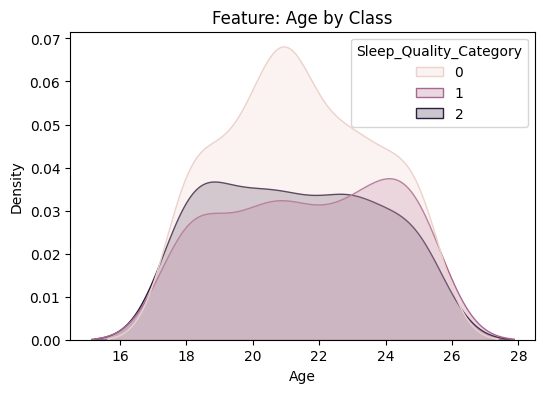

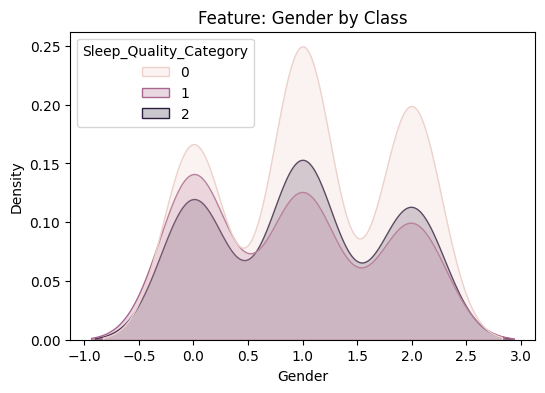

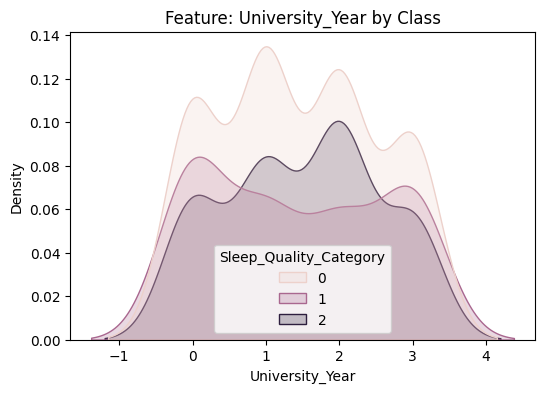

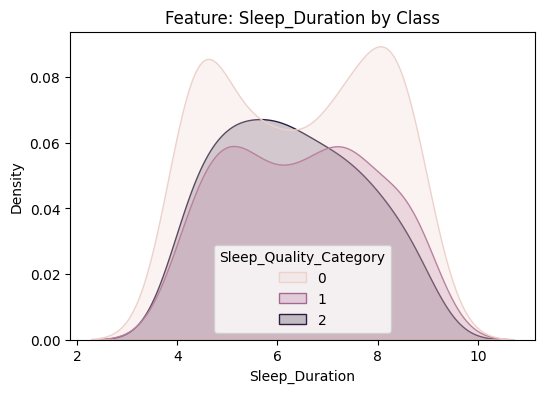

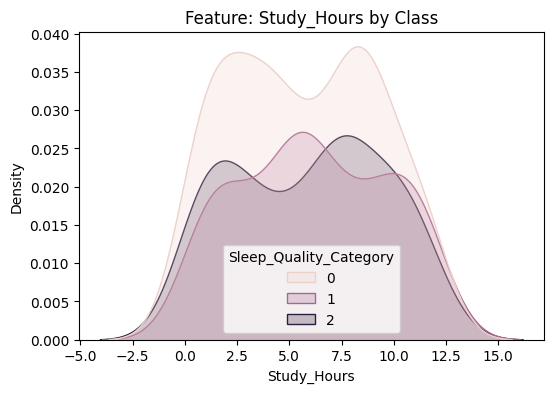

In [33]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Combine training features with target for per-class analysis
X_train_with_target = X_train.copy()
X_train_with_target['Sleep_Quality_Category'] = y_train

# 1. Check for multivariate normality using Shapiro-Wilk test (univariate approximation per class per feature)
print("=== Shapiro-Wilk Test for Normality (per class and feature) ===")
normality_results = []

for cls in sorted(X_train_with_target['Sleep_Quality_Category'].unique()):
    print(f"\nClass {cls}:")
    class_data = X_train_with_target[X_train_with_target['Sleep_Quality_Category'] == cls]
    for col in X_train.columns:
        stat, p = stats.shapiro(class_data[col])
        print(f"{col}: p-value = {p:.4f}")
        normality_results.append((cls, col, p))

# 2. Check for different covariance matrices using Box's M Test (using `pingouin` library)
from pingouin import box_m

# Combine X_train and y_train into one DataFrame
train_combined = X_train.copy()
train_combined['Group'] = y_train  # Group label (Sleep_Quality_Category)

# Now run Box's M test
boxm_result = box_m(data=train_combined, group='Group', dvs=X_train.columns.tolist())

print("\n=== Box's M Test for Equality of Covariance Matrices ===")
print(boxm_result)

# 3. Optional: Visualize feature distributions per class
print("\n=== KDE Plots per Feature by Class ===")
for col in X_train.columns[:5]:  # visualize first 5 features (can expand if needed)
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=X_train_with_target, x=col, hue='Sleep_Quality_Category', fill=True)
    plt.title(f"Feature: {col} by Class")
    plt.show()
